Mensini Chiara 5213336\
Vanotti Anna 5209632

# Rice Leaf Disease
The dataset has been downloaded from *Kaggle* ([Rice Leaf Disease](https://www.kaggle.com/datasets/maimunulkjisan/rice-leaf-dataset-from-mendeley-data/code)).
\
It consists of 5932 images of 4 different categories of rice leaf diseases:
1. **Bacterial blight** (1584 images)
2. **Blast** (1440 images)
3. **Brown spots** (1600 images)
4. **Tungro** (1308 images)

Understanding and analyzing rice leaf diseases are of paramount importance in agricultural research and crop management. The health of rice crops directly impacts global food security, as rice serves as a staple for a significant portion of the world's population. Detecting and diagnosing these diseases early through image analysis and machine learning techniques can aid farmers in implementing timely and targeted interventions, minimizing crop losses, and optimizing agricultural yields.

In [ ]:
%%capture
pip install d2l==1.0.0a1.post0

In [ ]:
# import libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import random
from PIL import Image
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
from d2l import torch as d2l
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'

extract_path = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(extract_path, exist_ok=True)

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
dataset_path= '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images'

# The dataset

It is now created a dataframe with the names of the images and their related category of disease. Below the first 5 rows of the dataset are displayed.

In [ ]:
# Label classes
categories = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

# Create the dataframe
filenames_list = []
categories_list = []

for category in categories:
    # Use os.path.join to concatenate paths
    category_path = os.path.join(dataset_path, category)

    # Take all file names for each category
    filenames = os.listdir(category_path)

    # Add file and category names to lists
    filenames_list += filenames
    categories_list += [category] * len(filenames)

# Create the dataframe
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle dataframe rows
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filename,category
0,BROWNSPOT7_147.jpg,Brownspot
1,BLAST5_088.jpg,Blast
2,BACTERAILBLIGHT5_092.jpg,Bacterialblight
3,BACTERAILBLIGHT4_228.JPG,Bacterialblight
4,BROWNSPOT1_010.jpg,Brownspot


## Data Visualization

### Visualization of the 4 Rice Leaf Diseases
In this section, an image will be displayed for each type of rice leaf diseases.

- **Bacterial blight**: it is caused by *Xanthomonas oryzae* pv. *oryzae*, resulting in wilting of seedlings and yellowing and drying of leaves.
- **Blast**: it is caused by the fungus *Magnaporthe oryzae*, resulting in initial symptoms of white to gray-green lesions or spots with dark green borders, evolving into older leaf lesions characterized by elliptical or spindle-shaped patterns, featuring whitish to gray centers and red to brownish or necrotic borders.
- **Brown spot**: it is a fungal disease, resulting in  circular to oval lesions with a light brown to gray center, surrounded by a reddish brown margin caused by the toxin produced by the fungi.
- **Tungro**: it is caused by *Rice tungro bacilliform virus* and *Rice tungro spherical virus*, resulting in  yellow or orange-yellow leaves and they may also have rust-colored spots.


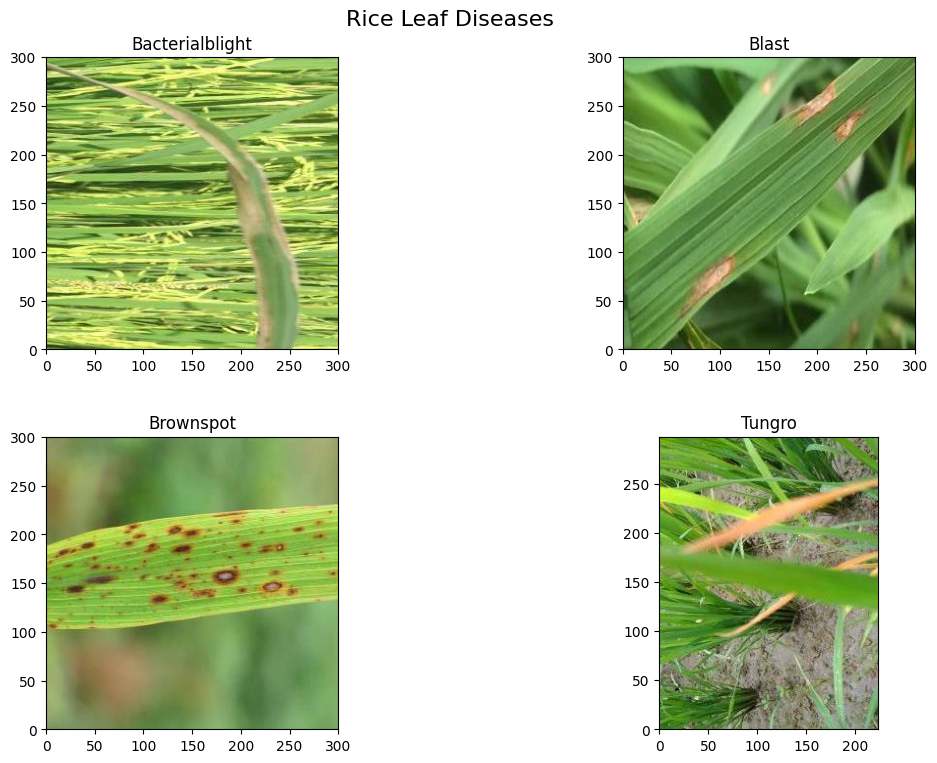

In [ ]:
np.random.seed(5222000)

grouped_df = df.groupby('category')
num_classes = len(grouped_df)
num_cols = 2
num_rows = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, (_, group) in enumerate(grouped_df):
    random_row = group.sample(1).iloc[0]

    image_path = os.path.join(dataset_path, random_row['category'], random_row['filename'])
    random_image = mpimg.imread(image_path)

    plt.subplot(num_rows, num_cols, i + 1)

    plt.title(random_row['category'])
    plt.imshow(random_image)

    plt.xlim([0, random_image.shape[1]])
    plt.ylim([0, random_image.shape[0]])

plt.suptitle('Rice Leaf Diseases', fontsize=16)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.3)
plt.show()

### Size and Color of the images
The analysis of image size and color plays an important role in the preparation and selection of neural network models for image-based tasks. Understanding the dimensions and color formats of images is essential for determining compatibility with specific neural network architectures and guiding necessary modifications in preprocessing. This preliminary examination ensures that chosen models can effectively handle the input images, providing insights into the adjustments needed for optimal performance in tasks such as image classification or detection.

As an example, here follows the size and color of images categorized as `Tungro`.

In [ ]:
# To see the size of the images and color

# Path containing images of Tungro disease
image_folder_path = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/Tungro'
# List of images in the folder
image_files = os.listdir(image_folder_path)

# Print the size of each image
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        mode = img.mode  # Return the color format of the image
        print(f"Name of the image: {image_file}, Dimension: {width} x {height}, Color format: {mode}")

Name of the image: TUNGRO1_001.jpg, Dimension: 215 x 287, Color format: RGB
Name of the image: TUNGRO1_002.jpg, Dimension: 216 x 289, Color format: RGB
Name of the image: TUNGRO1_003.jpg, Dimension: 230 x 306, Color format: RGB
Name of the image: TUNGRO1_004.jpg, Dimension: 214 x 284, Color format: RGB
Name of the image: TUNGRO1_005.jpg, Dimension: 216 x 288, Color format: RGB
Name of the image: TUNGRO1_006.jpg, Dimension: 210 x 280, Color format: RGB
Name of the image: TUNGRO1_007.jpg, Dimension: 219 x 292, Color format: RGB
Name of the image: TUNGRO1_008.jpg, Dimension: 216 x 289, Color format: RGB
Name of the image: TUNGRO1_009.jpg, Dimension: 220 x 294, Color format: RGB
Name of the image: TUNGRO1_010.jpg, Dimension: 217 x 289, Color format: RGB
Name of the image: TUNGRO1_011.jpg, Dimension: 223 x 296, Color format: RGB
Name of the image: TUNGRO1_012.jpg, Dimension: 212 x 283, Color format: RGB
Name of the image: TUNGRO1_013.jpg, Dimension: 215 x 286, Color format: RGB
Name of the 

## Check for the Balance of the Classes

The distribution of the 4 classes is balanced, ensuring a fair representation. Indeed, the ratios between each class and the total number of images are aligned. The least frequent class is `Tungro`, with 1308 observations, while the most frequent one is `Brownspot`, with 1600 observations.\
The need to maintain a proportional distribution of images across various disease types is important for promoting an unbiased and comprehensive analysis of rice leaf diseases.

Bacterialblight has 1584 images
Blast has 1440 images
Brownspot has 1600 images
Tungro has 1308 images


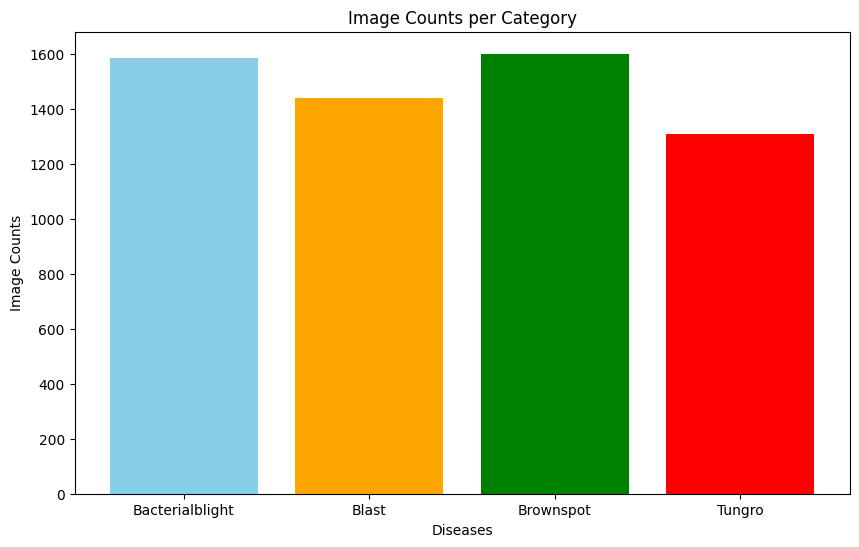

In [ ]:
# check distribution of dataframe

total_counts = 0
counts=[]
categories = []

for category in os.listdir(dataset_path): # iterate on labels
    count_class = 0
    for photo in os.listdir(dataset_path +'/'+ category): # iterate on filename
        count_class += 1
        total_counts += 1
        counts.append(count_class)
        categories.append(category)
    print(str(category) + " has " + str(count_class) + " images")

# Plotting the histogram
category_colors = {
    'Bacterialblight': 'skyblue',
    'Blast': 'orange',
    'Brownspot': 'green',
    'Tungro': 'red'
}

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=[category_colors[category] for category in categories])
plt.xlabel('Diseases')
plt.ylabel('Image Counts')
plt.title('Image Counts per Category')
plt.show()

## Data Preparation


### Create Balanced Sets

To train the model, it is necessary to create three new folders:
- **balanced training set**: to train data
- **balanced validation set**: to evaluate and improve model's generalization ability
- **balanced test set**: for final evaluation of the model's performance


Each of these three folders should contain 4 subfolders, each with the same number of images for every category.

In [ ]:
# Create a directory parallel to the classes folder
!mkdir '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/train_set'
!mkdir '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/test_set'
!mkdir '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/validation_set'

In [ ]:
train_set_path='/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/train_set'
test_set_path='/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/test_set'
validation_set_path='/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images/validation_set'

The 70% of images of the category with the lowest number of observations (`Tungro`), i.e. 915, is allocated in the training set, while the 15%, i.e. 195, for both the validation and test sets.

In [ ]:
def create_balanced_sets(rootdir, train_path, test_path,
                         validation_path, num_images_per_category_train= 915,
                         num_images_per_category_test= 195,
                         num_images_per_category_validation= 195):
    '''Create balanced sets with a specific number of images per category'''



    # Set the random seed
    random.seed(2252000)

    for set_name in [train_path, test_path, validation_path]:
        set_path = os.path.join(rootdir, set_name)
        os.makedirs(set_path, exist_ok=True)

    for category_name in os.listdir(rootdir):
        category_path = os.path.join(rootdir, category_name)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)

            # Check if there are enough images in the category
            if len(images) >= num_images_per_category_train + num_images_per_category_test + num_images_per_category_validation:
                # Randomly select images for the training set
                selected_images_train = random.sample(images, num_images_per_category_train)

                # Randomly select images for the test set
                remaining_images = list(set(images) - set(selected_images_train))
                selected_images_test = random.sample(remaining_images, num_images_per_category_test)

                # Randomly select images for the validation set
                remaining_images = list(set(remaining_images) - set(selected_images_test))
                selected_images_validation = random.sample(remaining_images, num_images_per_category_validation)

                # Create directories for the sets and move the selected images
                for set_name, selected_images in zip([train_path, test_path, validation_path], [selected_images_train, selected_images_test, selected_images_validation]):
                    set_category_path = os.path.join(rootdir, set_name, category_name)
                    os.makedirs(set_category_path, exist_ok=True)
                    for image in selected_images:
                        source_path = os.path.join(category_path, image)
                        destination_path = os.path.join(set_category_path, image)
                        shutil.move(source_path, destination_path)

# Modify the root path with your directory structure
root_directory = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images'
train_set_name = 'train_set'
test_set_name = 'test_set'
validation_set_name = 'validation_set'
create_balanced_sets(root_directory, train_set_name, test_set_name, validation_set_name)


The following code checks whether the classes in each sets are balanced.

In [ ]:
def count_images_per_category(rootdir):
    # it counts the number of images for each category in the sets
    for set_name in os.listdir(rootdir):
        set_path = os.path.join(rootdir, set_name)
        if os.path.isdir(set_path):
            print(f"Set: {set_name}")
            for category_name in os.listdir(set_path):
                category_path = os.path.join(set_path, category_name)
                if os.path.isdir(category_path):
                    num_images = len(os.listdir(category_path))
                    print(f"Category: {category_name}, Number of images: {num_images}")

# Modify the root path with your directory structure
root_directory = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Images'
count_images_per_category(root_directory)

Set: Bacterialblight
Set: Blast
Set: Brownspot
Set: Tungro
Set: train_set
Category: Bacterialblight, Number of images: 915
Category: Blast, Number of images: 915
Category: Brownspot, Number of images: 915
Category: Tungro, Number of images: 915
Set: test_set
Category: Bacterialblight, Number of images: 195
Category: Blast, Number of images: 195
Category: Brownspot, Number of images: 195
Category: Tungro, Number of images: 195
Set: validation_set
Category: Bacterialblight, Number of images: 195
Category: Blast, Number of images: 195
Category: Brownspot, Number of images: 195
Category: Tungro, Number of images: 195


### Training Set Preparation
As it can be observed at point *Size and Color of the images*, images have different sizes. Therefore it has been performed a resizing into *224x224* pixels and a trasnformation into tensors.

In [ ]:
# Resize and transform images in to tensor
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor()
                                     ])

In [ ]:
# Transformations application to the dataset, resizing of images and convertion to tensors.
train_dataset = torchvision.datasets.ImageFolder(root = train_set_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root = validation_set_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_set_path, transform=transform)

In [ ]:
# Create 3 new dataloader
BATCH_SIZE = 30
train_data_loader =DataLoader(train_dataset,BATCH_SIZE,shuffle=True,num_workers=2)
val_data_loader =DataLoader(val_dataset,BATCH_SIZE,shuffle=True,num_workers=2)
test_data_loader =DataLoader(test_dataset,BATCH_SIZE,shuffle=False,num_workers=2)

In [ ]:
# Create the iterators
data_train_iter = iter(train_data_loader)
data_val_iter = iter(val_data_loader)
data_test_iter = iter(test_data_loader)

# AlexNet


AlexNet, an 8-layer CNN, utilizes varying window sizes in its convolutional layers. The initial layer employs an *11x11* window, progressively reducing to *5x5* and *3x3* in subsequent layers. Notably, max-pooling layers with a *3x3* window and a stride of 2 are added after the first, second, and fifth convolutional layers.

Following the final convolutional layer, AlexNet features two expansive fully connected layers with 4096 outputs. A notable architectural choice is the utilization of the ReLU activation function, contributing to computational efficiency and enhancing the network's performance.

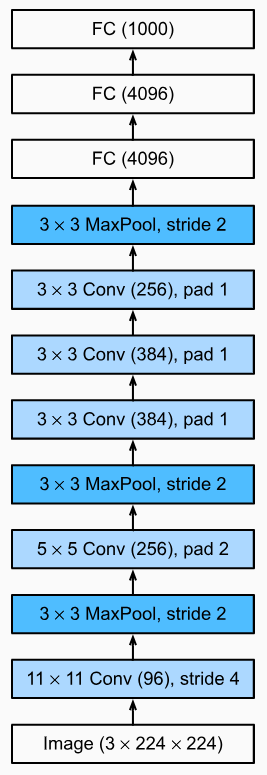

In [ ]:
net1 = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), # 3 because colored images
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Flatten(),
    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4))

In [ ]:
summary(net1, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         884,992
             ReLU-12          [-1, 256, 12, 12]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
          Flatten-14                 [-

# Model Training

During each epoch of model training, the mean loss is updated by iteratively evaluating it for each image in the training set. After processing all training images, the loss is reset to zero, and the accuracy is updated. This process monitors the model's performance on the training data throughout the epoch.

After completing an epoch, the model is evaluated on the validation set. The differences between true labels ($Y$) and predicted labels ($\hat Y$) are accumulated, and these differences are assessed using the accuracy metric.

The expectation is that if the training loss decreases and accuracy increases during an epoch, a similar trend should be observed in the validation set. Improved performance on the training data should generalize well to previously unseen validation data, resulting in a reduction of validation loss and an increase in accuracy. This consistency across training and validation metrics is indicative of the model's ability to learn and generalize effectively.

In [ ]:
def train_2(net, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    # Animator for accuracy
    acc_animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                                  legend=['Train Acc', 'Val Acc'])

    # Animator for loss
    loss_animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                                legend=['Train Loss', 'Val Loss'])

    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric_train = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric_train.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric_train[0] / metric_train[2]
            train_acc = metric_train[1] / metric_train[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                acc_animator.add(epoch + (i + 1) / num_batches,
                                   (train_acc, None, None, None, None))
                loss_animator.add(epoch + (i + 1) / num_batches,(train_l, None, None, None, None))

        # Validation phase
        metric_val = d2l.Accumulator(3)
        net.eval()

        for X_val, y_val in val_iter:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_hat_val = net(X_val)
            l_val = loss(y_hat_val, y_val)
            with torch.no_grad():
                metric_val.add(l_val * X_val.shape[0], d2l.accuracy(y_hat_val, y_val), X_val.shape[0])

        # Update validation metrics for the epoch
        val_l = metric_val[0] / metric_val[2]
        val_acc = metric_val[1] / metric_val[2]

        # Update animators
        acc_animator.add(epoch + 1, (None, val_acc, None, None, None))
        loss_animator.add(epoch + 1, (None, val_l, None, None, None))


    print(f'Train Loss {train_l:.3f}, Train Acc {train_acc:.3f}, Val Loss {val_l:.3f},'
          f'Val Acc {val_acc:.3f}')
    print(f'{metric_train[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')



Train Loss 0.644, Train Acc 0.748, Val Loss 0.547,Val Acc 0.783
636.7 examples/sec on cuda:0


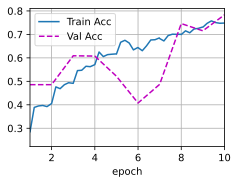

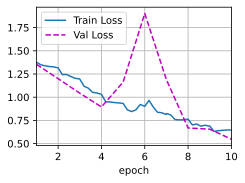

In [ ]:
np.random.seed(52200)

lr, num_epochs = 0.01, 10
train_2(net1, train_data_loader, val_data_loader, num_epochs, lr, device=d2l.try_gpu())

The previous graphs represent the behaviour of the Accuracy and the Loss of both the training and validation set at every epoch.

The training loss (blue line) is steadily decreasing over epochs, indicating effective model convergence, while the train accuracy (blue line) shows significant improvement, reaching a value of 75%. These results suggest that the model is learning effectively from the training data.

The validation loss (pink line) increases at epoch 6, indicating potential overfitting or changes in the complexity of the validation dataset. However, the validation loss subsequently decreases, suggesting early training dynamics where the model is still adjusting its parameters to learn underlying patterns in the data. This initial fluctuation might be attributed to noise or variability in the training data, and as training progresses, the model adapts and becomes more robust. The validation accuracy follows a similar trend, with a decline at the same epoch and a subsequent rise. These patterns might suggest that the model could benefit from regularization or other techniques to improve generalization.

# Testing

In [ ]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1=net1.to(device)

for num, data in enumerate(test_data_loader):
  # extract image and label
  image, label = data
  # move the data on the model GPU
  image, label = image.to(device), label.to(device)
  output = net1.forward(image)
  prediction = torch.argmax(output, 1)
  correct += (prediction == label).sum().item()

  total += len(label)

In [ ]:
print('Accuracy of test images: %d %%' % (100 * correct / total))

Accuracy of test images: 80 %


Despite the provided validation loss and accuracy values, the accuracy of test images is 80%. This may suggest that the model has achieved good generalization, as the performance on the test set is relatively close to that observed during validation.

# AlexNet BN

Because of the results obtained in the validation set, batch normalization has been introduced to mitigate normalization challenges and improve the overall performance and robustness of the neural network.

Batch normalization has been applied into the model after each convolutional and fully connected layer, following the `ReLU` activation and preceding any dropout layers.
\
The use of `BatchNorm2d` after convolutional layers and `BatchNorm1d` after fully connected layers ensures that the normalization process occurs after the activation functions.
\
Denote by $B$ a minibatch and let $x \in B $ be an input to batch normalization ($BN$). In this case the batch normalization is defined as follows:

$$
BN(x)= \gamma \odot \frac{x- \hat\mu_B}{\hat \sigma_B}+\beta
$$
where:
- $\hat \mu_B $ is the sample mean of the minibatch $B$ --> $\hat\mu_B=\frac{1}{|B|} \sum_{x \in B}x$
- $\hat \sigma_B$ is the sample standard deviation of the minibatch $B$ --> $\hat \sigma_B^2=\frac{1}{|B|}\sum_{x \in B}(x-\hat \mu_B^2)+\epsilon$
- $\gamma$ is a scale parameter
- $\beta$ is a shift parameter
- $\epsilon >0$ is a small constant to the variance estimate to ensure that there is no attempt of division by zero, even in cases where the empirical variance estimate might be very small or vanish.

\
Overall, this incorporation of batch normalization is expected to yield benefits in terms of training stability, convergence speed, and regularization, contributing to the overall effectiveness of the neural network.






In [ ]:
net = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
    nn.BatchNorm2d(96),  # Batch Normalization after the first convolutional layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.BatchNorm2d(256),  # Batch Normalization after the second convolutional layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.BatchNorm2d(384),  # Batch Normalization after the third convolutional layer
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.BatchNorm2d(384),  # Batch Normalization after the fourth convolutional layer
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),  # Batch Normalization after the fifth convolutional layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096),
    nn.BatchNorm1d(4096),  # Batch Normalization after the first fully connected layer
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.BatchNorm1d(4096),  # Batch Normalization after the second fully connected layer
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4)
)

In [ ]:
summary(net, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
       BatchNorm2d-2           [-1, 96, 54, 54]             192
              ReLU-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
       BatchNorm2d-6          [-1, 256, 26, 26]             512
              ReLU-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
      BatchNorm2d-10          [-1, 384, 12, 12]             768
             ReLU-11          [-1, 384, 12, 12]               0
           Conv2d-12          [-1, 384, 12, 12]       1,327,488
      BatchNorm2d-13          [-1, 384, 12, 12]             768
             ReLU-14          [-1, 384,

# Model Training BN

Train Loss 0.051, Train Acc 0.984, Val Loss 0.060,Val Acc 0.971
619.7 examples/sec on cuda:0


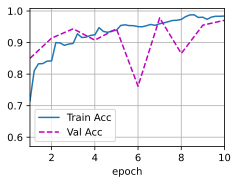

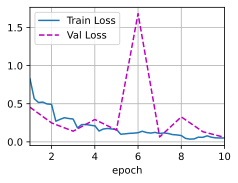

In [ ]:
np.random.seed(52200)

lr, num_epochs = 0.01, 10
train_2(net, train_data_loader, val_data_loader, num_epochs, lr, device=d2l.try_gpu())

The training process with batch normalization applied has demonstrated significant improvements in both training and validation metrics. The training loss (blue line) steadily decreased over epochs, reaching a very low value of 0.051, indicating effective model convergence. The training accuracy (blue line) also showed substantial improvement, achieving an accuracy of 98.4%. These results suggest that the model is learning efficiently from the training data, and batch normalization has contributed to a stable and effective training process.

During validation, there was a temporary increase in the validation loss (pink line) at epoch 6, followed by a notable decline, indicating some adjustments in the model's generalization. The validation accuracy (pink line) exhibits a similar pattern, with a brief decline and subsequent recovery. These trends suggest that the model, with the aid of batch normalization, adapts to the validation data characteristics, leading to improved generalization.

# Testing BN

In [ ]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=net.to(device)

for num, data in enumerate(test_data_loader):
  # extract image and label
  image, label = data
  # move the data on the model GPU
  image, label = image.to(device), label.to(device)
  output = net.forward(image)
  prediction = torch.argmax(output, 1)
  correct += (prediction == label).sum().item()

  total += len(label)

In [ ]:
print('Accuracy of test images: %d %%' % (100 * correct / total))

Accuracy of test images: 98 %


Despite fluctuations, the model achieves a high test accuracy of 98%.

# Image Visualization BN

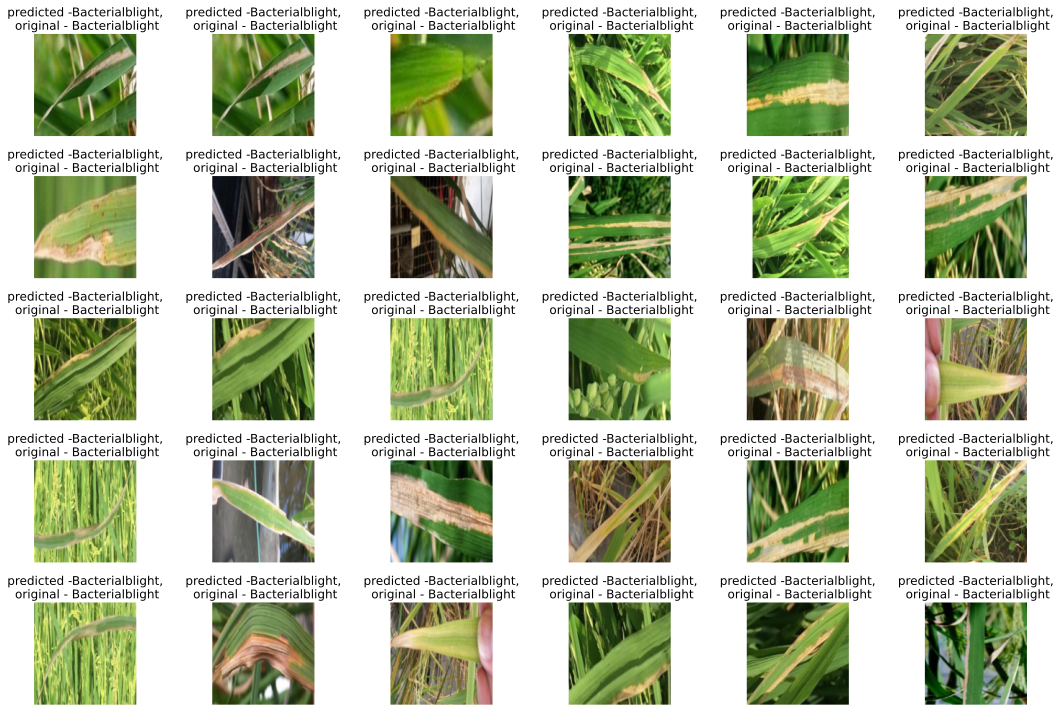

In [ ]:
# create iterator for test set
data_test_iter = iter(test_data_loader)
# get first bacth of test set
samples, labels = next(data_test_iter)
# move the input bacth on the GPU
samples = samples.to(device)

# Perform prediction on the input batch on the GPU
output = net(samples)

fig = plt.figure(figsize=(15, 12))
fig.tight_layout()

output = net(samples)
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

ad ={
    0: 'Bacterialblight', 1: 'Blast', 2: 'Brownspot', 3 : 'Tungro'
}

for num, sample in enumerate(samples):
    plt.subplot(6,6,num+1)
    plt.title(f'predicted -{ad[pred[num]]},\n original - {ad[int(labels[num])]}',loc='center', wrap=True)
    plt.axis('off')
    plt.tight_layout()
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

# Classification Report and Confusion Matrix BN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       195
           1       0.99      0.97      0.98       195
           2       0.97      0.98      0.98       195
           3       0.99      0.99      0.99       195

    accuracy                           0.98       780
   macro avg       0.98      0.98      0.98       780
weighted avg       0.98      0.98      0.98       780



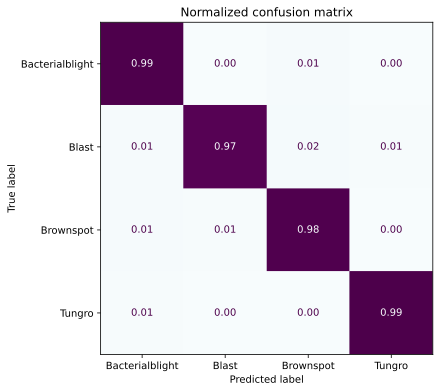

In [ ]:
# put the model on the GPU
net = net.to(device)

# create iterator for test set
data_test_iter = iter(test_data_loader)
# get first bacth of test set
samples, labels = next(data_test_iter)
# move the input bacth on the GPU
samples = samples.to(device)

# Perform prediction on the input batch on the GPU
output = net(samples)

net.eval()

pred = []
Y = []
for i, (x,y) in enumerate(test_data_loader):
    with torch.no_grad():
        x = x.to(device)
        outputs = net(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

categories = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

plot_confusion_matrix(pred, Y, categories)

- **Accuracy** provides a measure of how well the model is performing in terms of correctly classifying instances.\
It is calculated as $Accuracy=\frac{TP+TN}{Total}$, where *TP+TN* is the number of correct predictions, while *Total* is the number of predictions.
- **Precision** is a measure of how many of the predicted positive instances are actually positive. \
It is calculated as $Precision=\frac{TP}{TP+FP}$, where $TP$ are the instances that are correctly predicted as positive and $FP$ are the instances that are incorrectly predicted as positive.
- **Recall** measures the ability of a model to correctly identify all relevant instances (positives) out of the total actual positive instances. It quantifies the model's ability to avoid false negatives. \
It is calculated as $Recall=\frac{TP}{TP+FN}$, where $TP$ are the instances that are correctly predicted as positive and $FN$ are the instances that are actually positive but incorrectly predicted as negative.
- **F1-score** is the armonic mean of **Precision** and **Recall**.\
It is calculated as $F1-score=\frac{2 \cdot Precsion \cdot Recall}{Precision+Recall}$

\


The classification report indicates strong performance of the model in distinguishing between plant disease categories.\
These results indicate the model's effectiveness in accurately identifying instances of these diseases, with minimal occurrences of false positives and false negatives.

The overall accuracy of 98% underscores the model's ability to make correct predictions across all classes. Both macro and weighted averages, also at 98%, emphasize the model's consistent and reliable performance.


For what concerns the confusion matrix, each row corresponds to the true class, while each column represents the predicted class. The color intensity in each cell reflects the recall.
\
Strong diagonal elements can be observed for all the categories, while off-diagonal elements are low.


In conclusion, the model exhibits robust classification capabilities for various plant diseases.
